# Import

In [11]:
import os

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [12]:
X = tf.placeholder(tf.float32, shape=[None, 16])
Z = tf.placeholder(tf.float32, shape=[None, 10])

# Set up parameters for generator and discriminator

In [13]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
size_g_w1 = 10
size_g_b1 = 32
# A good way to decide the std for initializing the weights
w1_std = 1.0/tf.sqrt(size_g_w1/2.0)

G_W1 = tf.Variable(tf.random_normal(shape=[size_g_w1, size_g_b1], stddev=w1_std))
G_b1 = tf.Variable(tf.zeros(shape=[size_g_b1]))

size_g_w2 = 32
size_g_b2 = 16
w2_std = 1.0/tf.sqrt(size_g_w2/2.0)

G_W2 = tf.Variable(tf.random_normal(shape=[size_g_w2, size_g_b2], stddev=w2_std))
G_b2 = tf.Variable(tf.zeros(shape=[size_g_b2]))
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 16
size_d_b1 = 8
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 8
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator module

In [14]:
def generator(z,x):

    G_h1 = tf.nn.relu(tf.matmul(tf.cast(z,tf.float32), G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_res = tf.nn.tanh(G_logit)
    
    G_r = 0.5 * (x * tf.reduce_max(G_res) - x * tf.reduce_min(G_res) + tf.reduce_max(G_res)  + tf.reduce_min(G_res))

    return G_r
    

# Discriminator module

In [15]:
def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Generate samples function

In [16]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n])

# Faciliate the path defining process

In [17]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

from pathlib import Path
#get the current path of our code
code_dir = Path().resolve()
#create output_dir within the same path
output_dir = os.path.join(code_dir, 'outputGANs/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# Build GNN with defined vars and functions

In [18]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample = generator(Z,X)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

# Load the data

In [19]:
import pandas as pd
df = pd.read_csv("Normalized_GSPC.csv")
data = df['Data']
window_size=16
x, y = [], []
for l in range(0,len(data)-window_size):
    x.append(np.array(data.iloc[l:l+window_size]))
    y.append([np.array(data.iloc[l+window_size]),0])
x, y = np.array(x).reshape(len(data)-window_size,window_size),np.array(y).reshape(len(data)-window_size,2)

# define the next batch function

In [20]:
# def next_batch(data, batchSize):
#     #Return a total of `batchSize` random samples
#     idx = np.arange(0, len(data))
#     np.random.shuffle(idx)
#     idx = idx[:batchSize]
#     data_shuffle = np.array([data[i] for i in idx])
#     return data_shuffle

def next_batch(data, batchSize, itern):
    itern = itern % len(data)
    if(itern+batchSize < len(data)):
        idx = np.arange(itern, itern+batchSize)
    else:
        idx1 = np.arange(itern,len(data))
        idx2 = np.arange(0,itern+batchSize-len(data))
        idx = np.append(idx1,idx2)
    #idx = idx[:batchSize]
    data_batch = np.array([data[i] for i in idx])
    return data_batch

# Start the session

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 4
# the dimension of the random samples
z_dim = 10
result_freq = 100


min_iter = 0
max_iter = int(len(y)/batch_size) * 100 
i = 0

for iter in range(min_iter,max_iter):
    
    itern = iter * batch_size
    batch_xs = next_batch(x,batch_size,itern)

    _, discriminator_loss = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim),X: batch_xs})

    res = generator(sample_z(batch_size, z_dim),batch_xs).eval(session=sess)
    
    itern = itern % len(y)
    if(itern+batch_size < len(y)):
        y[itern :itern+batch_size,1] = res[:,15]
    else:
        y[itern:len(y),1] = res[0:len(y)-itern,15]
        y[0:itern+batch_size-len(y),1] = res[len(y)-itern:,15]
    
    if iter % result_freq == 0:
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss))
        print('G_loss: {:0.4}'.format(generator_loss))
        print()


iteration: 0
D_loss: 1.548
G_loss: 0.8025

iteration: 100
D_loss: 1.409
G_loss: 0.8219

iteration: 200
D_loss: 1.437
G_loss: 0.6179

iteration: 300
D_loss: 1.424
G_loss: 0.6568

iteration: 400
D_loss: 1.429
G_loss: 0.6347

iteration: 500
D_loss: 1.347
G_loss: 0.6349

iteration: 600
D_loss: 1.405
G_loss: 0.807

iteration: 700
D_loss: 1.405
G_loss: 0.7801

iteration: 800
D_loss: 1.388
G_loss: 0.7041

iteration: 900
D_loss: 1.386
G_loss: 0.6758

iteration: 1000
D_loss: 1.384
G_loss: 0.6511

iteration: 1100
D_loss: 1.387
G_loss: 0.7127

iteration: 1200
D_loss: 1.388
G_loss: 0.701

iteration: 1300
D_loss: 1.394
G_loss: 0.7525

iteration: 1400
D_loss: 1.388
G_loss: 0.728

iteration: 1500
D_loss: 1.387
G_loss: 0.6792

iteration: 1600
D_loss: 1.386
G_loss: 0.6983

iteration: 1700
D_loss: 1.387
G_loss: 0.7198

iteration: 1800
D_loss: 1.389
G_loss: 0.6635

iteration: 1900
D_loss: 1.386
G_loss: 0.7045

iteration: 2000
D_loss: 1.387
G_loss: 0.7024

iteration: 2100
D_loss: 1.386
G_loss: 0.6972

ite

KeyboardInterrupt: 

In [22]:
np.savetxt("result.csv", y, delimiter=',')

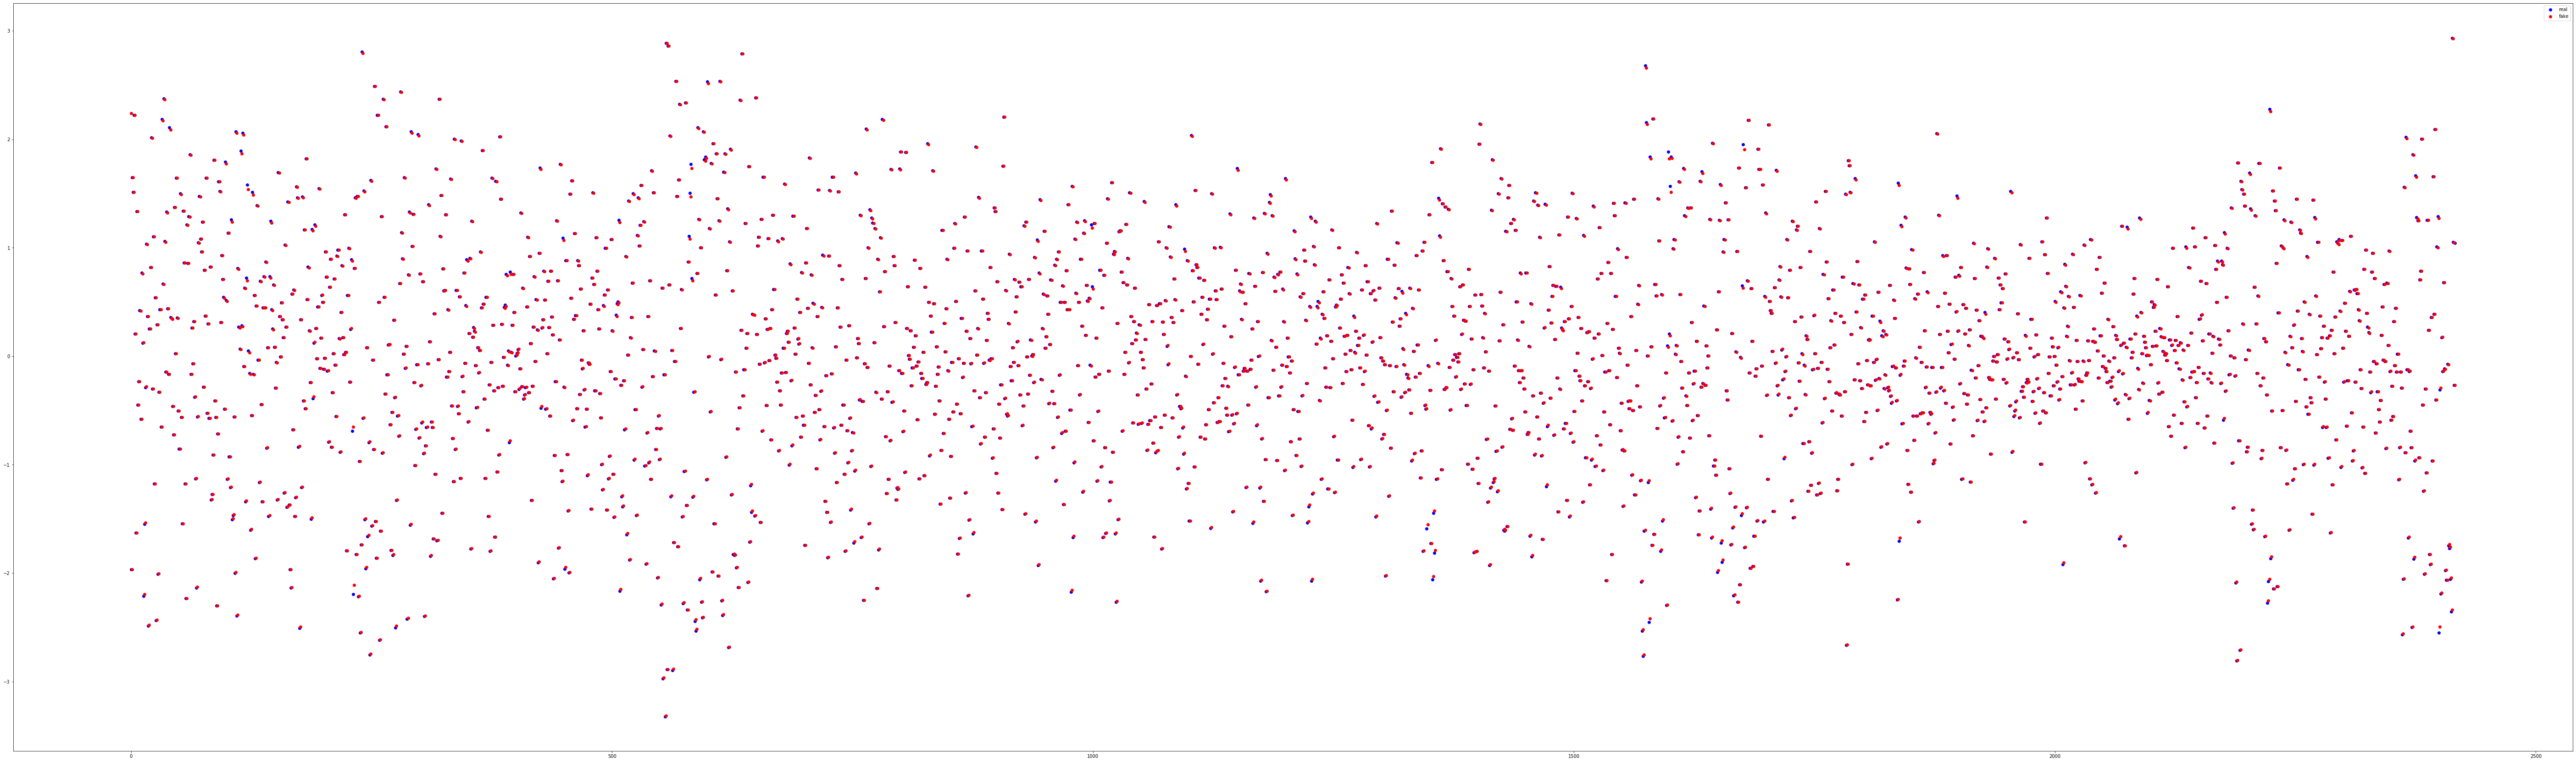

In [23]:
plt.figure(figsize=(100,30))
x = range(0,len(y))
plt.scatter(x,y[:,0],color='b',label='real')
plt.scatter(x,y[:,1],color='r',label='fake')
plt.legend()
plt.show()
plt.savefig('plot.png')
plt.close()

From the plot, we can see that we experience model collapse after 4000 iterations and the generator can only generate data that exactly looks like the real data. 